In [123]:
# Importing essential libraries for web scraping, data manipulation, and machine learning evaluation.

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor


### dataset is scraped from Turbo.az 
### web scraping project link: https://github.com/heydar432/Web-scraping/tree/main/Turbo.az%20web%20scraping%20project

In [124]:
# Read Excel data into DataFrame

df = pd.read_excel(r'C:\Users\Heydar\Desktop\Data Science\My_projects\Kia_marka_linear_regression_price_pred/Turbo_az_Kia_all_vehicles.xlsx')

# Remove unneeded columns from DataFrame

del df['Contact_number']
del df['Product_link']
del df['Unnamed: 0']
del df['Brand']

In [125]:
df = df.drop_duplicates()

In [127]:
# columns which inside have 'değer yok' so 'None' values:

none_columns_list = ['Owner Count', 'Origin','Condition', 'Seat Count']

print('None_proportion :')
for i in none_columns_list:
    print(i, round(len(df[df[i]=='değer yok'])/len(df),4))



None_proportion :
Owner Count 0.3058
Origin 0.2732
Condition 0.0013
Seat Count 0.2336


### Data preprocessing and feature engineering for the DataFrame


In [128]:

# Splitting 'Price' into numeric value and currency type
split_result = df['Price'].str.split(' ', n=2, expand=True)
df['Price'] = split_result[0]+split_result[1]
df['currency'] = split_result[2]

# Converting 'Price' to integer type and adjusting it to USD
df['Price'] = df['Price'].astype('int')
df['Adjusted_Price (USD)'] = df.apply(lambda row: round((row['Price'] / 1.7),3) if row['currency'] == 'AZN' else row['Price'], axis=1)

# Extracting engine details and condition features
df[['volume_motor', 'hp', 'oil_type']] = df['Engine Details'].str.split('/', expand=True)
df[['crash','Painted']] = df['Condition'].str.split(',', expand=True)

# Deleting columns that are no longer needed
del df['Engine Details']
del df['Condition']

# Extracting mileage, engine volume, and horsepower features
df['Mileage (km)'] = df['Mileage'].str.split('km', n=1).str[0]
df['volume_motor (L)'] = df['volume_motor'].str.split('L', n=1).str[0]
df['HP'] = df['hp'].str.split('a.g.', n=1).str[0]

# Deleting temporary columns
del df['Mileage']
del df['volume_motor']
del df['hp']
del df['Price']
del df['currency']

# Cleaning and converting columns to proper types
df['Mileage (km)'] = df['Mileage (km)'].str.replace(' ','').astype(int)
df['HP'] = df['HP'].str.replace(' ','').astype(int)
df['volume_motor (L)'] = df['volume_motor (L)'].str.replace(' ','').astype(float)
df['Painted'] = df['Painted'].str.replace(' ','')

# Save original values to use for reverting back from NaN
original_values = df['Seat Count'].copy()

# Use pd.to_numeric to convert valid numbers to numeric and set invalid parsing to NaN
df['Seat Count'] = pd.to_numeric(df['Seat Count'], errors='coerce')

# Use fillna to replace NaN with original string values
df['Seat Count'] = df['Seat Count'].fillna(original_values)

In [129]:
df_copy = df.copy()


In [130]:
# Encoding categorical variables through mapping
city_mapping = {'Bakı': 1}
df['City'] = df['City'].map(city_mapping).fillna(0).astype(int)

trans_mapping = {'Avtomat': 3,'Mexaniki':2, 'Robotlaşdırılmış':1}
df['Transmission'] = df['Transmission'].map(trans_mapping)

isnew_mapping = {'Bəli': 1,'Xeyr': 0}
df['İs_New?'] = df['İs_New?'].map(isnew_mapping)

# Converting categorical variables to frequency encoding
for i in ['Body Type','Color','Drive Type','oil_type']:
    df[i] = df[i].map(df[i].value_counts(normalize=True).to_dict())

df['Seat Count'] = df.apply(lambda row: 5 if row['Model'] == 'Clarus' else row['Seat Count'], axis=1)

target_encoder = ce.TargetEncoder()
df['Model'] = target_encoder.fit_transform(df['Model'], df['Adjusted_Price (USD)'])

# Update 'Owner Count' to 0 if 'Mileage (km)' is 0, else keep as is.

df['Owner Count'] = df.apply(lambda row: 0 if row['Mileage (km)'] == 0 else row['Owner Count'], axis=1)

# Filter rows where the 'Saler_name' column contains "Kia Motors", case-insensitive
filtered_df = df[df['Saler_name'].str.contains('Kia Motors', case=False, na=False)]

# Create a dictionary where keys are the index of the rows in filtered_df and values are 1
filtered_index_map = {index: 1 for index in filtered_df.index}

# Map the dictionary to a new column, filling non-matching rows with 0
df['Saler_name'] = df.index.map(filtered_index_map).fillna(0).astype(int)

# filling null values
df['Painted'].fillna(df['Painted'].mode()[0], inplace=True)

# Replacing missing or 'değer yok' values in 'crash' column with the most frequent value (mode)
df['crash'] = df['crash'].replace('değer yok', df['crash'].mode()[0])

# Function to replace 'değer yok' with the mode 'Seat Count' value for the same 'Model'
def replace_deger_yok_with_mode(group):
    mode_value = group[group != 'değer yok'].mode().iloc[0] if not group[group != 'değer yok'].mode().empty else 'değer yok'
    return group.replace('değer yok', mode_value)

# Apply the function within each 'Model' group using transform
df['Seat Count'] = df.groupby('Model')['Seat Count'].transform(replace_deger_yok_with_mode)

# to replace 'değer yok' with the mode 'Origin' value for the same 'Model'
df['Origin'] = df.groupby('Model')['Origin'].transform(replace_deger_yok_with_mode)

crash_mapping = {'Vuruğu yoxdur': 1,'Vuruğu var': 0}
df['crash'] = df['crash'].map(crash_mapping)

painted_mapping = {'rənglənməyib': 1,'rənglənib': 0}
df['Painted'] = df['Painted'].map(painted_mapping)

df['Origin'] = df['Origin'].map(df['Origin'].value_counts(normalize=True).to_dict())

# Replace 'değer yok' with NaN in the 'Owner Count' column
df['Owner Count'].replace('değer yok', float('NaN'), inplace=True)

# Replacing '4 və daha çox' in 'Owner Count' with integer 4 and '8+' in 'Seat Count' with integer 8, then converting 'Seat Count' to integer type

df['Owner Count'].replace('4 və daha çox', int(4), inplace=True)

df['Seat Count'].replace('8+', int(8), inplace=True)

df['Seat Count'] = df['Seat Count'].astype(int)

# Count the occurrences of each unique value in 'crash' column
value_counts = df['crash'].value_counts(normalize=True)

# Find the missing values
missing_values = df['crash'].isna()

# Fill missing values based on the distribution of non-missing values
df.loc[missing_values, 'crash'] = np.random.choice(value_counts.index, size=missing_values.sum(), p=value_counts.values)

# convert to to numeric before modelling
df = df.apply(pd.to_numeric, errors='coerce')

# If 'Mileage (km)' is 0, set 'Owner Count' to 0
df.loc[df['Mileage (km)'] == 0, 'Owner Count'] = 0


# If 'Mileage (km)' is not 0 and 'Owner Count' is 0, set 'Owner Count' to 1
df.loc[(df['Mileage (km)'] != 0) & (df['Owner Count'] == 0), 'Owner Count'] = 1


### Filling 'None' values using Random Forest Classifier algorithm

# Separate columns
X = df.drop('Owner Count', axis=1)  # Features
y = df['Owner Count']  # Target

# Separate rows with and without 'NaN' in 'Owner Count'
X_missing = X[y.isnull()]
y_missing = y[y.isnull()]

X_not_missing = X[y.notnull()]
y_not_missing = y[y.notnull()]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_not_missing, y_not_missing, test_size=0.2)

# Train the model
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print("Owner Count variable none filling Accuracy:", accuracy_score(y_test, y_pred))

# Predict and fill missing values
y_missing_pred = clf.predict(X_missing)
df.loc[y.isnull(), 'Owner Count'] = y_missing_pred

Owner Count variable none filling Accuracy: 0.6


### Price Prediction with Regression Algorithm

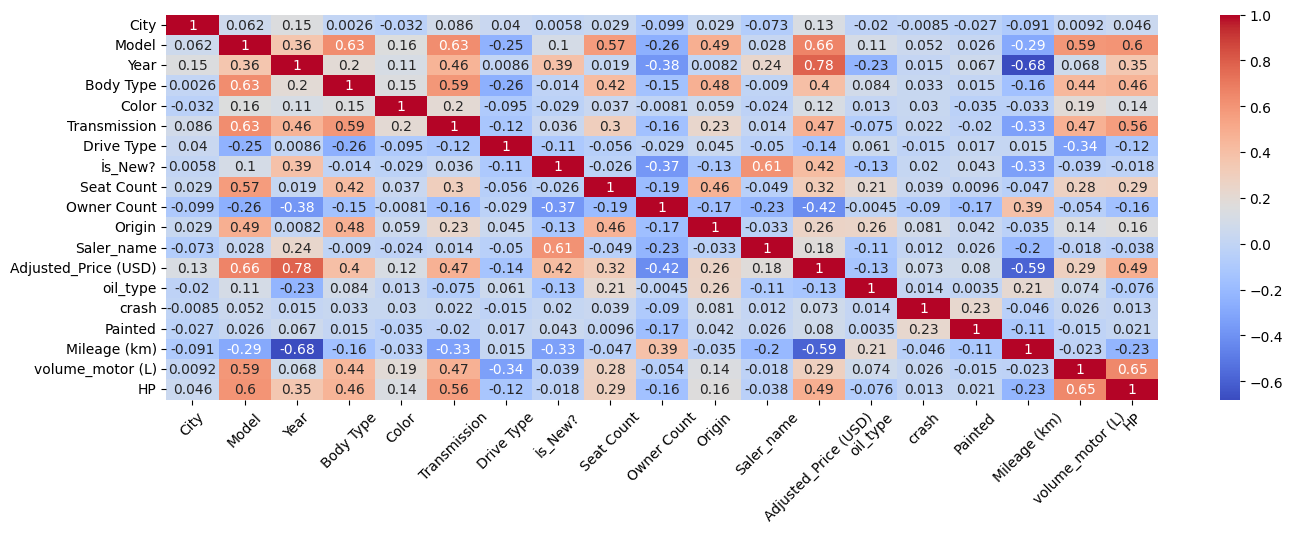

In [131]:
# Create a figure and set the size
plt.figure(figsize=(16, 5))

# Calculate the correlation matrix
corr_matrix = df.corr()

# Generate a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [132]:
# there is neither high pozitife nor high negative correlation between independent variables. so there is no multicollinearity problem

In [133]:
# Set display format for pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [134]:
# Calculate scores after removing features that do not contribute significantly to the model

# Set display format for pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Separate columns 
X = df.drop(['Adjusted_Price (USD)', 'crash', 'Painted'], axis=1) # removing features that do not contribute significantly to the model or is unnecessary
y = df['Adjusted_Price (USD)']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel


# Create and fit the XGBoost regressor
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=3, alpha=10, n_estimators=100)
model.fit(X_train, y_train)

# Feature selection
selector = SelectFromModel(model, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Get the boolean mask indicating which features are selected
selected_features_mask = selector.get_support()

# Get the names of the selected features from X_train
selected_column_names = X_train.columns[selected_features_mask]

# Print the selected column names
print("Selected features:", selected_column_names)

Selected features: Index(['Model', 'Year', 'Transmission', 'İs_New?', 'Mileage (km)', 'HP'], dtype='object')


In [136]:
base_models = [
    ('dt', DecisionTreeRegressor(random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=70, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1, max_depth=3, alpha=10, n_estimators=100)),
    ('catboost', CatBoostRegressor(random_state=42, silent=True)),
    ('svr', SVR())
]

from sklearn.metrics import mean_squared_error

model_performance = []

for name, model in base_models:
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_pred)
    model_performance.append((name, mse))

    # Print the model name and its MSE
    print(f"Model: {name}, Mean Squared Error: {round(mse,3)}")

# Sort the models based on MSE
model_performance.sort(key=lambda x: x[1])

# Select the top 2 models
top_models = model_performance[:2]
print("Top 2 models:", top_models)

# Extract the model instances for the top 2 models
top_model_instances = [model for name, model in base_models if name in [m[0] for m in top_models]]

# Create the stacking regressor with the top 2 models
stacked_model = StackingRegressor(
    estimators=[(name, model) for name, model in base_models if name in [m[0] for m in top_models]],
    final_estimator=LinearRegression(),
    cv=5
)

# Fit the stacked model
stacked_model.fit(X_train_selected, y_train)

# Predict and evaluate the stacked model
stacked_pred = stacked_model.predict(X_test_selected)
stacked_mse = mean_squared_error(y_test, stacked_pred)
print("Stacked Model MSE:", round(stacked_mse, 3))


Model: dt, Mean Squared Error: 5886314.187
Model: rf, Mean Squared Error: 3128512.905
Model: gb, Mean Squared Error: 3262730.291
Model: xgb, Mean Squared Error: 8594224.901
Model: catboost, Mean Squared Error: 2728195.24
Model: svr, Mean Squared Error: 61503903.549
Top 2 models: [('catboost', 2728195.239912073), ('rf', 3128512.905059937)]
Stacked Model MSE: 2677752.348


In [137]:
model = stacked_model

In [138]:
# Initialize the main lookup dictionary
lookup_dict = {}

# Populate the dictionary
for col in df.columns:
    lookup_dict[col] = {}
    for i, val in enumerate(df[col]):
        lookup_val = df_copy.iloc[i][col]
        lookup_dict[col][lookup_val] = val

# Example lookups
lookup_values = ['Ceed',2008,'Mexaniki','Xeyr',180000,109]  # These are the values you want to look up

# Finding the corresponding values
corresponding_values = {}
for val in lookup_values:
    for col, mapping in lookup_dict.items():
        if val in mapping:
            corresponding_values[val] = mapping[val]

print(f"Corresponding values in df: {corresponding_values}")

print('Predicted Price (USD):',(model.predict(np.array(list(corresponding_values.values())).reshape(1,-1))))

Corresponding values in df: {'Ceed': 9108.9824660016, 2008: 2008, 'Mexaniki': 2, 'Xeyr': 0, 180000: 180000, 109: 109}
Predicted Price (USD): [8501.22410974]


In [142]:
# dump model as pikle file

import pickle

with open(r'C:\Users\Heydar\Desktop\Data Science\My_projects\Kia_marka_linear_regression_price_pred\model_2.pkl', 'wb') as file:
    pickle.dump(model, file)

# dump lookup_dict as pikle file

with open(r'C:\Users\Heydar\Desktop\Data Science\My_projects\Kia_marka_linear_regression_price_pred\lookup_dict.pkl', 'wb') as file:
    pickle.dump(lookup_dict, file)